<div align="center">
    <img src="https://pica.zhimg.com/70/v2-a491a7e651c77c8f91b2789a343ba1ac_1440w.awebp?source=172ae18b&biz_tag=Post" width=60% height=60% alt="" />
    <h4>
      Cellpose: a generalist algorithm for cellular segmentation
    </h4>
</div>

# What Is ***cellpose?***
Cellpose is an open-source software tool and Python library designed for the automatic segmentation of cells in biomedical images, particularly in microscopy images. It was developed to streamline the process of identifying and segmenting individual cells within complex biological samples, making it a valuable tool for a wide range of applications in the fields of cell biology, neuroscience, and medical research.

**Journal:** Nature methods<br>
**DOI:** https://www.nature.com/articles/s41592-020-01018-x<br>
**Preprint Date:** December 14, 2020<br>
**Github:** https://github.com/MouseLand/cellpose<br>
**Tutorial:** https://cellpose.readthedocs.io/en/latest/<br>
**Environment (mirror):** Cellpose(URL: (URL: https://cloud.stomics.tech/#/public/image))

# **Tutorial**      
This code is used to segment cells in images. It includes steps such as image preprocessing, cell segmentation, post-processing, and image merging, ultimately producing segmented binary images.[Click](https://cellpose.readthedocs.io/en/latest/gui.html#training-your-own-cellpose-modelhttps://cellpose.readthedocs.io/en/latest/gui.html#training-your-own-cellpose-model) here for more tutorials. In this tutorial, we demonstrate how to apply <strong>cellpose</strong> algorithm.

# **Input and Output**  
 
 >Input:the input of the original image is `*.tif`, the image type like 'FB' and 'mIf'...        
 >Output:the mask of cell segmentation will be saved in `*tif`, and the output value is binary, 0 or 255. 

# **Demo Data** 

|**Data**|**Size**|**Type**|**Platform**|**Donwload**|
|:----:|:----:|:----:|:----:|:----:|
|data1| 512-508 | FB | Stereo-seq | [http://www.cellpose.org/dataset](http://www.cellpose.org/dataset) |
|data2| 512-512 | mIf | Stereo-seq | [http://www.cellpose.org/dataset](http://www.cellpose.org/dataset) |
     

> Notes: this demo data are saved on cloud [click here](https://bgipan.genomics.cn/#/link/RMxRTwf7MrSPHwDsF2P9) (PWD:fgTG)


# **Time Estimates** 
|**Data size**|**CPU Core**|**CPU Menory (G)**|**GPU Memory (G)**|**Running Time (min)**|
|:----:|:----:|:----:|:----:|:----:|
|512-508|8|~1.7|~0|~5|


<details close>
<summary><b><font size="4">Parameters</b></summary>

- Input Image Path (open_path): Specifies the file path of the input image for cell segmentation.
- Output Image Path (save_path): Specifies the file path to save the segmentation results.
- Image Block Size (photo_size): Specifies the size of image blocks used for segmentation.
- Image Block Step (photo_step): Specifies the step size between image blocks.
- Minimum Cell Diameter (dmin): Specifies the minimum diameter of cells.
- Maximum Cell Diameter (dmax): Specifies the maximum diameter of cells.
- Step (step): Specifies the step size for cell diameters.
</details>

# **Import Packages and Load Data**
# **setup plugins**
Download [Cellpose.zip](https://bgipan.genomics.cn/#/link/RMxRTwf7MrSPHwDsF2P9)(password：fgTG) and and put it into the notebook pathway './work/'. then unpacked files.

In [1]:
!unzip Cellpose.zip 

Archive:  Cellpose.zip
  inflating: 330_img.tif             
  inflating: 339_img.tif             
   creating: cellpose/
  inflating: cellpose/__init__.py    
  inflating: cellpose/__main__.py    
  inflating: cellpose/core.py        
  inflating: cellpose/dynamics.py    
  inflating: cellpose/io.py          
  inflating: cellpose/metrics.py     
  inflating: cellpose/models.py      
   creating: cellpose/models/
  inflating: cellpose/models/cellpose_residual_on_style_on_concatenation_off_train1_2022_10_28_16_59_59.600570  
  inflating: cellpose/models/cellpose_residual_on_style_on_concatenation_off_train_2023_06_20_15_14_14.218607_epoch_9951  
  inflating: cellpose/models/CP      
  inflating: cellpose/models/CP_20230619_095147  
  inflating: cellpose/models/CPx     
  inflating: cellpose/models/cyto2torch_0  
  inflating: cellpose/models/cyto2torch_1  
  inflating: cellpose/models/cyto2torch_2  
  inflating: cellpose/models/cyto2torch_3  
  inflating: cellpose/models/cytotorch_0  
 

# **Import packages**

In [1]:
import cv2
import numpy as np
from math import ceil
import patchify
from scipy.ndimage import distance_transform_edt
import numpy as np
from urllib.parse import urlparse
import time, os, sys
from math import ceil
import patchify
import cv2
import tifffile as tf
import matplotlib.pyplot as plt
import sys 
sys.path.append('.cellpose') 
sys.path.insert(0,'cellpose')
from cellpose import io, models, utils

class CellSegmentation:
    def __init__(self, open_path, save_path, photo_size, photo_step, dmin, dmax, step):
        self.open_path = open_path
        self.save_path = save_path
        self.photo_size = photo_size
        self.photo_step = photo_step
        self.dmin = dmin
        self.dmax = dmax
        self.step = step

    def _process_image(self, img_data):
        overlap = self.photo_size - self.photo_step
        if (overlap % 2) == 1:
            overlap = overlap + 1
        act_step = ceil(overlap / 2)
        im = cv2.imread(self.open_path)
        dir_image1 = self.open_path.split('/')[-1].strip('.tif')
        image = np.array(im)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        res_image = np.pad(gray_image, ((act_step, act_step), (act_step, act_step)), 'constant')
        a = res_image.shape[0]
        b = res_image.shape[1]
        res_a = ceil((a-self.photo_size)/self.photo_step)*self.photo_step+self.photo_size
        res_b = ceil((b-self.photo_size)/self.photo_step)*self.photo_step+self.photo_size
        padding_rows = res_a - a
        padding_cols = res_b - b
        regray_image = np.pad(res_image, ((0, padding_rows), (0, padding_cols)), mode='constant')
        patches = patchify.patchify(regray_image, (self.photo_size, self.photo_size), step=self.photo_step)     
        wid = patches.shape[0]
        high = patches.shape[1]
        model = models.Cellpose(gpu=True, model_type='cyto')
        a_patches = np.full((wid, high, (self.photo_step), (self.photo_step)), 255)

        for i in range(wid):
            for j in range(high):
                img_data = patches[i, j, :, :]
                num0min = wid * high * 800000000000000
                for k in range(self.dmin, self.dmax, self.step):

                    masks, flows, styles, diams = model.eval(img_data, diameter=k, channels=[0, 0], flow_threshold=0.9)
                    num0 = np.sum(masks == 0)

                    if num0 < num0min:
                        num0min = num0
                        outlines = utils.masks_to_outlines(masks)
                        outlines = (outlines == True).astype(int) * 255

                        try:
                            a_patches[i, j, :, :] = outlines[act_step:(self.photo_step+act_step), act_step:(self.photo_step+act_step)]
                            output = masks.copy()
                        except:
                            a_patches[i, j, :, :] = output[act_step:(self.photo_step+act_step), act_step:(self.photo_step+act_step)]

        patch_nor = patchify.unpatchify(a_patches, ((wid) * (self.photo_step), (high) * (self.photo_step)))
        nor_imgdata = np.array(patch_nor)
        cropped_1 = nor_imgdata[0:gray_image.shape[0], 0:gray_image.shape[1]]
        cropped_1 = np.uint8(cropped_1)
        return cropped_1

    def _post_image(self, process_image):
        contour_thickness = 0
        contour_coords = np.argwhere(process_image == 255)
        distance_transform = distance_transform_edt(process_image == 0)
        expanded_image = np.zeros_like(process_image)
        for y, x in contour_coords:
            mask = distance_transform[y, x] <= contour_thickness
            expanded_image[y - contour_thickness:y + contour_thickness + 1, x - contour_thickness:x + contour_thickness + 1] = mask * 255
        contours, _ = cv2.findContours(expanded_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        height, width = process_image.shape
        black_background = np.zeros((height, width), dtype=np.uint8)
        for contour in contours:
            area = cv2.contourArea(contour)
            if 20 < area < 10000:
                cv2.drawContours(black_background, [contour], -1, 255, thickness=cv2.FILLED)
        black_background = np.uint8(black_background)
        return black_background, expanded_image

    def _merger_image(self, merger_image1, merger_image2):
        merger_image1[merger_image2==255]=0
        return merger_image1

    def segment_cells(self):
        inverted_image = self._process_image(self.open_path)
        post_image, expanded_image = self._post_image(inverted_image)
        result_image = self._merger_image(post_image, expanded_image)
        cv2.imwrite(self.save_path, result_image)
        contours, _ = cv2.findContours(inverted_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)       
        h, w = result_image.shape[:2]
        outline = np.zeros((h, w, 3), dtype=np.uint8)
        img = cv2.imread(self.open_path)
        if img.ndim == 2:
            show_r = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
        else:
            show_r = img.copy()
        cv2.drawContours(show_r, contours=contours, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(show_r)
        plt.title('Cell Segmentation, number of cells:{}'.format(len(contours)))
        areas = [cv2.contourArea(c) for c in contours]
        plt.subplot(1, 2, 2)
        plt.hist(areas, bins=len(areas) // 20, range=(0,len(areas)), color='skyblue', alpha=0.8)
        plt.title('Cell area')
        plt.xlabel('Value (pix)')
        plt.ylabel('Frequency')
        plt.show()


# **Run data**
- Scene 1: Inference for FB

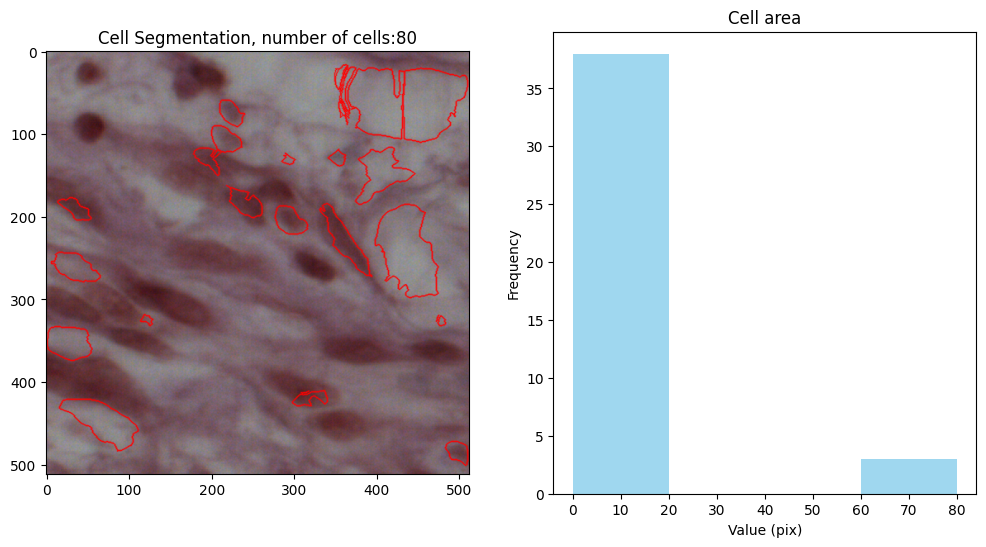

In [3]:
open_path = "/storeData/USER/data/01.CellBin/00.user/fanjinghong/code/benchmark/input/NuInsSeg/tissue_images/human_bladder_01.tif"
save_path = "/storeData/USER/data/01.CellBin/00.user/fanjinghong/code/benchmark/output/NuInsSeg/339_img_mask.tif"
photo_size = 512
photo_step = 512
dmin = 30
dmax = 40
step = 5

cell_segmenter = CellSegmentation(open_path, save_path, photo_size, photo_step, dmin, dmax, step)
cell_segmenter.segment_cells()

- Scene 2: Inference for mIf

In [ ]:
open_path = "./330_img.tif"
save_path = "./330_img_mask.tif"
photo_size = 512
photo_step = 512
dmin = 30
dmax = 40
step = 5

cell_segmenter = CellSegmentation(open_path, save_path, photo_size, photo_step, dmin, dmax, step)
cell_segmenter.segment_cells()

# **Contact Information**
For questions about this notebook, please contact: _cloud@stomics.tech_.

# **Cite**
If you use STOmics/Stereo-seq data in your research, please considering referring us in your article:
> **Code available** The source code of this algorithm is available at Github (https://github.com/MouseLand/cellpose). The visual and convenient execution of this algorithm can be found from STOmics Cloud Platform (https://cloud.stomics.tech/).

> **Acknowledgement** We express our gratitude to the computing platform STOmics Cloud (https://cloud.stomics.tech/) for enabling workflow automation and accelerating Stereo-seq data analysis. If you use STOmics/Stereo-seq data in your research, please considering referring us in your article.